# DecisionTreeClassifier

Un árbol de decisión es un modelo muy simple, intuitivo e interpretable. Resulta muy útil analizar sus resultados para detectar predictores fuertes y features irrelevantes, para poder afinar los preprocessings de modelos más complejos y mejorar su eficiencia. Se entrenaron dos árboles de decisión con preprocessings distintos: uno más sencillo y otro más sofisticado.

In [1]:
%load_ext autoreload
%autoreload 2
from preprocessing import *
from sklearn.metrics import roc_auc_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer, MissingIndicator
import pandas as pd
import numpy as np
from joblib import dump, load

## Métricas y scorings

In [2]:
SCORINGS = ["f1", "roc_auc", "accuracy", "recall", "precision"]
METRIC = "roc_auc"

def tabla(grid, params):
    tabla = pd.DataFrame(grid.cv_results_)
    tabla.sort_values("rank_test_" + METRIC, inplace = True)
    tabla.reset_index(inplace = True)
    cols = ["param_tree__" + x for x in params] + ["mean_test_" + x for x in SCORINGS]
    return tabla[cols]

## Preprocessing Nº1

In [3]:
initialize_dataset()
df_features = pd.read_csv("datasets/df_features.csv", low_memory = False, index_col = "id")
df_target = pd.read_csv("datasets/df_target.csv", low_memory=False, index_col = "id")

common(df_features, df_target)

df_features = dummy(df_features, [
    "direccion_viento_tarde",
    "direccion_viento_temprano",
    "rafaga_viento_max_direccion",
    "barrio"
])

### Grid search de hiperparámetros

In [4]:
parameters = {
    "tree__criterion": [
        "gini",
        "entropy"
    ],
    "tree__max_depth": np.arange(1,15,1),
    "tree__min_samples_split": np.arange(200,600,30)
}

pipe = Pipeline([
    ("imp", SimpleImputer()),
    ("tree", DecisionTreeClassifier(random_state=0))
])

grid = GridSearchCV(pipe, param_grid=parameters,
                                       cv = 5,
                                       scoring = SCORINGS,
                                       refit=METRIC,
                                       n_jobs = -1)

grid.fit(df_features, df_target.values.ravel())
grid.best_score_

0.8547047178252157

In [5]:
tabla(grid, ["criterion", "max_depth", "min_samples_split"]).head(10)

,param_tree__criterion,param_tree__max_depth,param_tree__min_samples_split,mean_test_f1,mean_test_roc_auc,mean_test_accuracy,mean_test_recall,mean_test_precision
0,entropy,13,530,0.573382,0.854705,0.839659,0.481363,0.709062
1,entropy,14,530,0.573366,0.854669,0.839561,0.481625,0.708449
2,entropy,13,560,0.575336,0.854668,0.839991,0.484245,0.708837
3,entropy,14,590,0.572207,0.854604,0.839874,0.478701,0.711752
4,entropy,13,590,0.572167,0.854603,0.839923,0.478483,0.712129
5,entropy,14,560,0.575298,0.854592,0.839893,0.484463,0.708247
6,entropy,14,500,0.573231,0.854517,0.839463,0.481713,0.708207
7,entropy,13,500,0.572085,0.854452,0.839454,0.479487,0.709460
8,entropy,12,530,0.572983,0.854290,0.839717,0.480403,0.709932
9,entropy,12,560,0.575074,0.854270,0.840059,0.483502,0.709582


Vemos que los mejores modelos fueron los que utilizaron ***entropy*** como criterio de separación. Esto coincide con lo esperado, ya que se sabe que generalmente funciona mejor, aunque suele ser un poco más lento que ***gini***, por requerirse el cálculo de un logaritmo

### Importancia de cada feature

In [6]:
pd.DataFrame(zip(df_features.columns, grid.best_estimator_[1].feature_importances_), columns=["feature", "importancia"])\
.set_index("feature")\
.sort_values(by="importancia", ascending=False)\
.head(20)

,importancia
feature,
humedad_tarde,0.586583
presion_atmosferica_tarde,0.096337
rafaga_viento_max_velocidad,0.085602
horas_de_sol,0.080468
mm_lluvia_dia,0.054241
nubosidad_tarde,0.010076
temperatura_tarde,0.009468
temperatura_temprano,0.008102
temp_max,0.007202


Las features que el modelo considero más importantes coinciden con las analizadas en el TP1

In [7]:
pd.DataFrame(zip(df_features.columns, grid.best_estimator_[1].feature_importances_), columns=["feature", "importancia"])\
.set_index("feature")\
.sort_values(by="importancia", ascending=False)\
.tail(20)

,importancia
feature,
direccion_viento_temprano_Oeste,0.0
direccion_viento_temprano_Oestenoroeste,0.0
direccion_viento_temprano_Sur,0.0
direccion_viento_temprano_suroeste,0.0
barrio_Flores,0.0
direccion_viento_temprano_nan,0.0
rafaga_viento_max_direccion_Estenoreste,0.0
rafaga_viento_max_direccion_Estesureste,0.0
rafaga_viento_max_direccion_Noroeste,0.0


Vemos que los barrios y las direcciones de viento no fueron útiles para el modelo utilizando One Hot Encoding. Para el segundo preprocessing, se utilizaron encodings diferentes para comparar resultados.

In [8]:
dump(grid.best_estimator_, 'DecisionTreeClassifier/preprocessing1.joblib') 

['DecisionTreeClassifier/preprocessing1.joblib']

## Preprocessing Nº2

In [9]:
initialize_dataset()
df_features = pd.read_csv("datasets/df_features.csv", low_memory = False, index_col = "id")
df_target = pd.read_csv("datasets/df_target.csv", low_memory=False, index_col = "id")

common(df_features, df_target, fecha_to_int=False)
viento_trigonometrico(df_features)
df_features = barrios_a_comunas(df_features)
df_features = dia_a_mes(df_features)

### Grid search de hiperparámetros

In [10]:
# Reducimos un poco la busqueda a los valores cercanos
# a los encontrados con el primer preprocessing
parameters = {
    "tree__max_depth": np.arange(8,15,1),
    "tree__min_samples_split": np.arange(400,600,25)
}

pipe = Pipeline([
    ("imp", SimpleImputer()),
    ("tree", DecisionTreeClassifier(criterion="entropy", random_state=0))
])

grid = GridSearchCV(pipe, param_grid=parameters,
                                       cv = 5,
                                       scoring = SCORINGS,
                                       refit=METRIC,
                                       n_jobs = -1)

grid.fit(df_features, df_target.values.ravel())
grid.best_score_

0.8558635174119373

In [11]:
tabla(grid, ["max_depth", "min_samples_split"]).head(10)

,param_tree__max_depth,param_tree__min_samples_split,mean_test_f1,mean_test_roc_auc,mean_test_accuracy,mean_test_recall,mean_test_precision
0,10,575,0.572394,0.855864,0.840568,0.476911,0.716852
1,10,525,0.572879,0.855853,0.840685,0.477347,0.716791
2,10,475,0.571535,0.855806,0.840196,0.476125,0.715189
3,10,400,0.575901,0.855803,0.840538,0.483677,0.712235
4,10,550,0.574172,0.855792,0.840431,0.480665,0.713315
5,10,450,0.572348,0.855776,0.840411,0.477129,0.715769
6,11,400,0.576370,0.855742,0.840098,0.485859,0.708546
7,10,500,0.570580,0.855735,0.840255,0.474117,0.716730
8,12,400,0.575297,0.855692,0.839844,0.484549,0.708196
9,10,425,0.574202,0.855687,0.840294,0.481058,0.712686


Los resultados son ligeramente mejores que en el primer preprocessing (85.66% vs. 85.47% en AUC ROC). En cuanto a los hiperparámetros encontrados, vemos que los árboles resultantes son menos profundos y, por lo tanto, más simples. Esto es algo bueno, ya que quiere decir que tiene más posibilidades de generalizar mejor y tener mejores resultados en instancias no vistas anteriormente

### Importancia de cada feature

In [12]:
pd.DataFrame(zip(df_features.columns, grid.best_estimator_[1].feature_importances_), columns=["feature", "importancia"])\
.set_index("feature")\
.sort_values(by="importancia", ascending=False)\
.head(20)

,importancia
feature,
humedad_tarde,0.604631
presion_atmosferica_tarde,0.096488
rafaga_viento_max_velocidad,0.086653
horas_de_sol,0.079984
mm_lluvia_dia,0.055274
sin_viento_tarde,0.012597
nubosidad_tarde,0.008600
temperatura_tarde,0.007798
temperatura_temprano,0.007736


Podemos observar que el preprocessing ***viento_trigonometrico*** fue de utilidad, ya que las features relacionadas a la dirección del viento ganaron importancia en el árbol

In [13]:
pd.DataFrame(zip(df_features.columns, grid.best_estimator_[1].feature_importances_), columns=["feature", "importancia"])\
.set_index("feature")\
.sort_values(by="importancia", ascending=False)\
.tail(20)

,importancia
feature,
barrio_Comuna 10,0.001842
cos_rafaga_viento_max_direccion,0.001841
cos_viento_temprano,0.000870
mm_evaporados_agua,0.000865
sin_rafaga_viento_max_direccion,0.000686
barrio_Comuna 5,0.000667
barrio_Comuna 15,0.000459
barrio_Comuna 4,0.000372
velocidad_viento_temprano,0.000206


El hashing de los barrios no resultó tan útil. Como genera un aumento considerable de la dimensionalidad del dataset, en futuros modelos debería considerarse la posibilidad de descartar la feature completa

In [14]:
dump(grid.best_estimator_, 'DecisionTreeClassifier/preprocessing2.joblib') 

['DecisionTreeClassifier/preprocessing2.joblib']

### Matriz de confusión

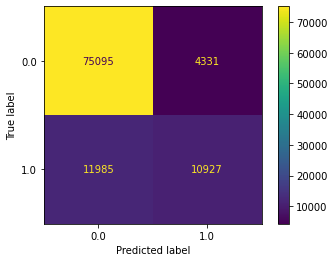

In [16]:
ConfusionMatrixDisplay.from_predictions(df_target, cross_val_predict(grid.best_estimator_, df_features, df_target))

Podemos ver que la cantidad de falsos negativos es mas del doble de la cantidad de falsos positivos. Esto se debe a que el dataset se encontraba desbalanceado, por lo que el modelo tiende a devolver 0 con más frecuencia, ya que en las hojas tendrá mayor cantidad de instancias negativas que positivas.

## Cambiando los pesos de las clases

Podemos intentar solucionar el problema anterior modificando el parámetro ***class_weight*** para que modifique la importancia de cada clase de la variable target en funcion de su frecuencia en el dataset

In [23]:
parameters = {
    "tree__max_depth": np.arange(8,15,1),
    "tree__min_samples_split": np.arange(400,600,50)
}

pipe = Pipeline([
    ("imp", SimpleImputer()),
    ("tree", DecisionTreeClassifier(criterion="entropy", class_weight="balanced", random_state=0))
])

grid = GridSearchCV(pipe, param_grid=parameters,
                                       cv = 5,
                                       scoring = SCORINGS,
                                       refit=METRIC,
                                       n_jobs = -1)

grid.fit(df_features, df_target.values.ravel())
grid.best_score_

0.855390150154539

In [24]:
tabla(grid, ["max_depth", "min_samples_split"]).head(10)

,param_tree__max_depth,param_tree__min_samples_split,mean_test_f1,mean_test_roc_auc,mean_test_accuracy,mean_test_recall,mean_test_precision
0,11,550,0.606266,0.855390,0.776173,0.769596,0.500285
1,10,550,0.606354,0.855233,0.777228,0.766148,0.501928
2,10,500,0.607580,0.855145,0.779095,0.763616,0.504734
3,10,450,0.607729,0.855140,0.779251,0.763485,0.504986
4,10,400,0.607403,0.855138,0.779378,0.762045,0.505111
5,11,500,0.607932,0.855081,0.779124,0.764795,0.504598
6,13,550,0.605000,0.854990,0.773163,0.775837,0.495909
7,12,550,0.603168,0.854989,0.770388,0.779242,0.492100
8,11,450,0.608797,0.854941,0.780131,0.763966,0.506197
9,14,550,0.603850,0.854938,0.771023,0.779460,0.492847


Los mejores modelos resultaron ser más simples (menor profundidad) y mantuvieron el AUC ROC entre los mismos valores (aunque las otras métricas cambiaron)

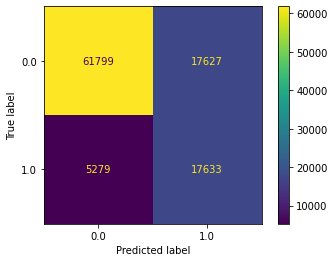

In [25]:
ConfusionMatrixDisplay.from_predictions(df_target, cross_val_predict(grid.best_estimator_, df_features, df_target))

Vemos que la cantidad de instancias predichas correctamente disminuyó (lo cual se ve reflejado en la accuracy del modelo), asi como la cantidad de falsos negativos y verdaderos positivos

In [26]:
pd.DataFrame(zip(df_features.columns, grid.best_estimator_[1].feature_importances_), columns=["feature", "importancia"])\
.set_index("feature")\
.sort_values(by="importancia", ascending=False)\
.head(20)

,importancia
feature,
humedad_tarde,0.571949
rafaga_viento_max_velocidad,0.114047
horas_de_sol,0.082923
presion_atmosferica_tarde,0.079044
mm_lluvia_dia,0.050665
sin_viento_tarde,0.016842
temp_max,0.008939
nubosidad_tarde,0.008674
sin_viento_temprano,0.008434


La importancia de las features se mantuvo similar, aunque podemos ver que ***rafaga_viento_max_velocidad*** aumentó un poco.

El modelo resultante no fue superador, ya que el anterior fue un poco más simple (1 nivel menos profundo) y el score no aumentó

In [27]:
dump(grid.best_estimator_, 'DecisionTreeClassifier/balanced.joblib') 

['DecisionTreeClassifier/balanced.joblib']